<a href="https://colab.research.google.com/github/Gabriel-boop-deep/Petro_manchas/blob/main/Petron_simplificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Nessa versão, irei separar as bibliotecas do código, com o objetivo de organizar melhor a lógica e ter uma melhor compreensão do que estou fazendo.

##Instalando as bibliotecas

In [ ]:
!pip install icrawler       > /dev/null     # dica: ao adicional             > /dev/null     a instalação ocorre de forma silenciosa, sem output.
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
import warnings      # dica: você também pode silenciar avisos ignorando-os
warnings.filterwarnings("ignore")
from shutil import rmtree
#rmtree('/content/images')   #deleta tudo no diretório caso você queira recomeçar
from random import Random
import shutil
import os
!pip install fastai > /dev/null
from fastai.vision.all import *
from fastai.vision.augment import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!pip install -q gradio
import gradio
from gradio.components import Image, Label

###Nesse momento, farei a função que irá capturar as imagens da web para começar a divisão de mares com ou sem petróleo

In [ ]:
# Define a função que baixa as imagens
def take_images(keyword, max_num_img, server): # Informações
    # Esta biblioteca pode deixar de funcionar caso solicite mais de 1000 imagens
    # Roda o scraper
    local = f'./images/downloaded/{keyword}'
    if server == 'google':
        crawler = GoogleImageCrawler(storage={'root_dir': local})
    if server == 'bing':
        crawler = BingImageCrawler(storage={'root_dir': local})
    crawler.crawl(keyword=keyword, max_num=max_num_img)



# baixa diversas imagens de uma lista de classes
classes = ['Mar com machas de petroleo','Mar sem manchas de petroleo']
for classe in classes:
    take_images(classe, max_num_img=500, server='bing')

ERROR:downloader:Response status code 403, file https://laverdadnoticias.com/__export/1573491780782/sites/laverdad/img/2019/11/11/derrame_de_petrxleo_en_playas_de_tabasco_provoca_tragedia_ambiental.jpg
ERROR:downloader:Exception caught when downloading file http://www.blogentretenido.com/wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg, error: HTTPConnectionPool(host='www.blogentretenido.com', port=80): Max retries exceeded with url: /wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f80023d0b20>: Failed to establish a new connection: [Errno -2] Name or service not known')), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file http://www.blogentretenido.com/wp-content/uploads/2015/10/enorme-mancha-en-el-mar-estaba-viva-pensaban-que-era-petroleo-1024x576.jpg, error: HTTPConnecti

###Separar os dados de treino e os dados de teste a partir das imagens obtidas na internet

In [ ]:
keys = []

os.path.sep = '/'
!cd "/content/"
for root, dirs, files in os.walk("./images/downloaded/"):
    for filename in files:
        keys.append(f"{root}/{filename}")

# Randomizar os inputs. (Vamos eliminar possibilidade de viés por ordem)
seed = 2022
randomizer = Random(seed)
randomizer.shuffle(keys)

input_files = []

for key in keys:
    input_files.append(key)

# Separa 20% dos dados para validação
test_split_size = 0.10
split_idx = int(len(input_files) * test_split_size)

train_input_files = input_files[:-split_idx]
val_input_files = input_files[-split_idx:]

# Criar diretórios para os dados de treino e validação
for file_train in train_input_files:
    train_path = f"./images/train/{file_train.split('/')[-2]}"
    os.makedirs(train_path, exist_ok=True)
    shutil.copy(file_train, f"{train_path}/{file_train.split('/')[-1]}")

for file_valid in val_input_files:
    valid_path = f"./images/valid/{file_valid.split('/')[-2]}"
    os.makedirs(valid_path, exist_ok=True)
    shutil.copy(file_valid, f"{valid_path}/{file_valid.split('/')[-1]}")

print(f'Train input files: {len(train_input_files)}')
print(f'Val input files: {len(val_input_files)}')

Train input files: 320
Val input files: 35


###Faremos nessa etapa, o carregamento e a vizualização das imagens que o modelo foi capaz de gerar e já com as classificações.

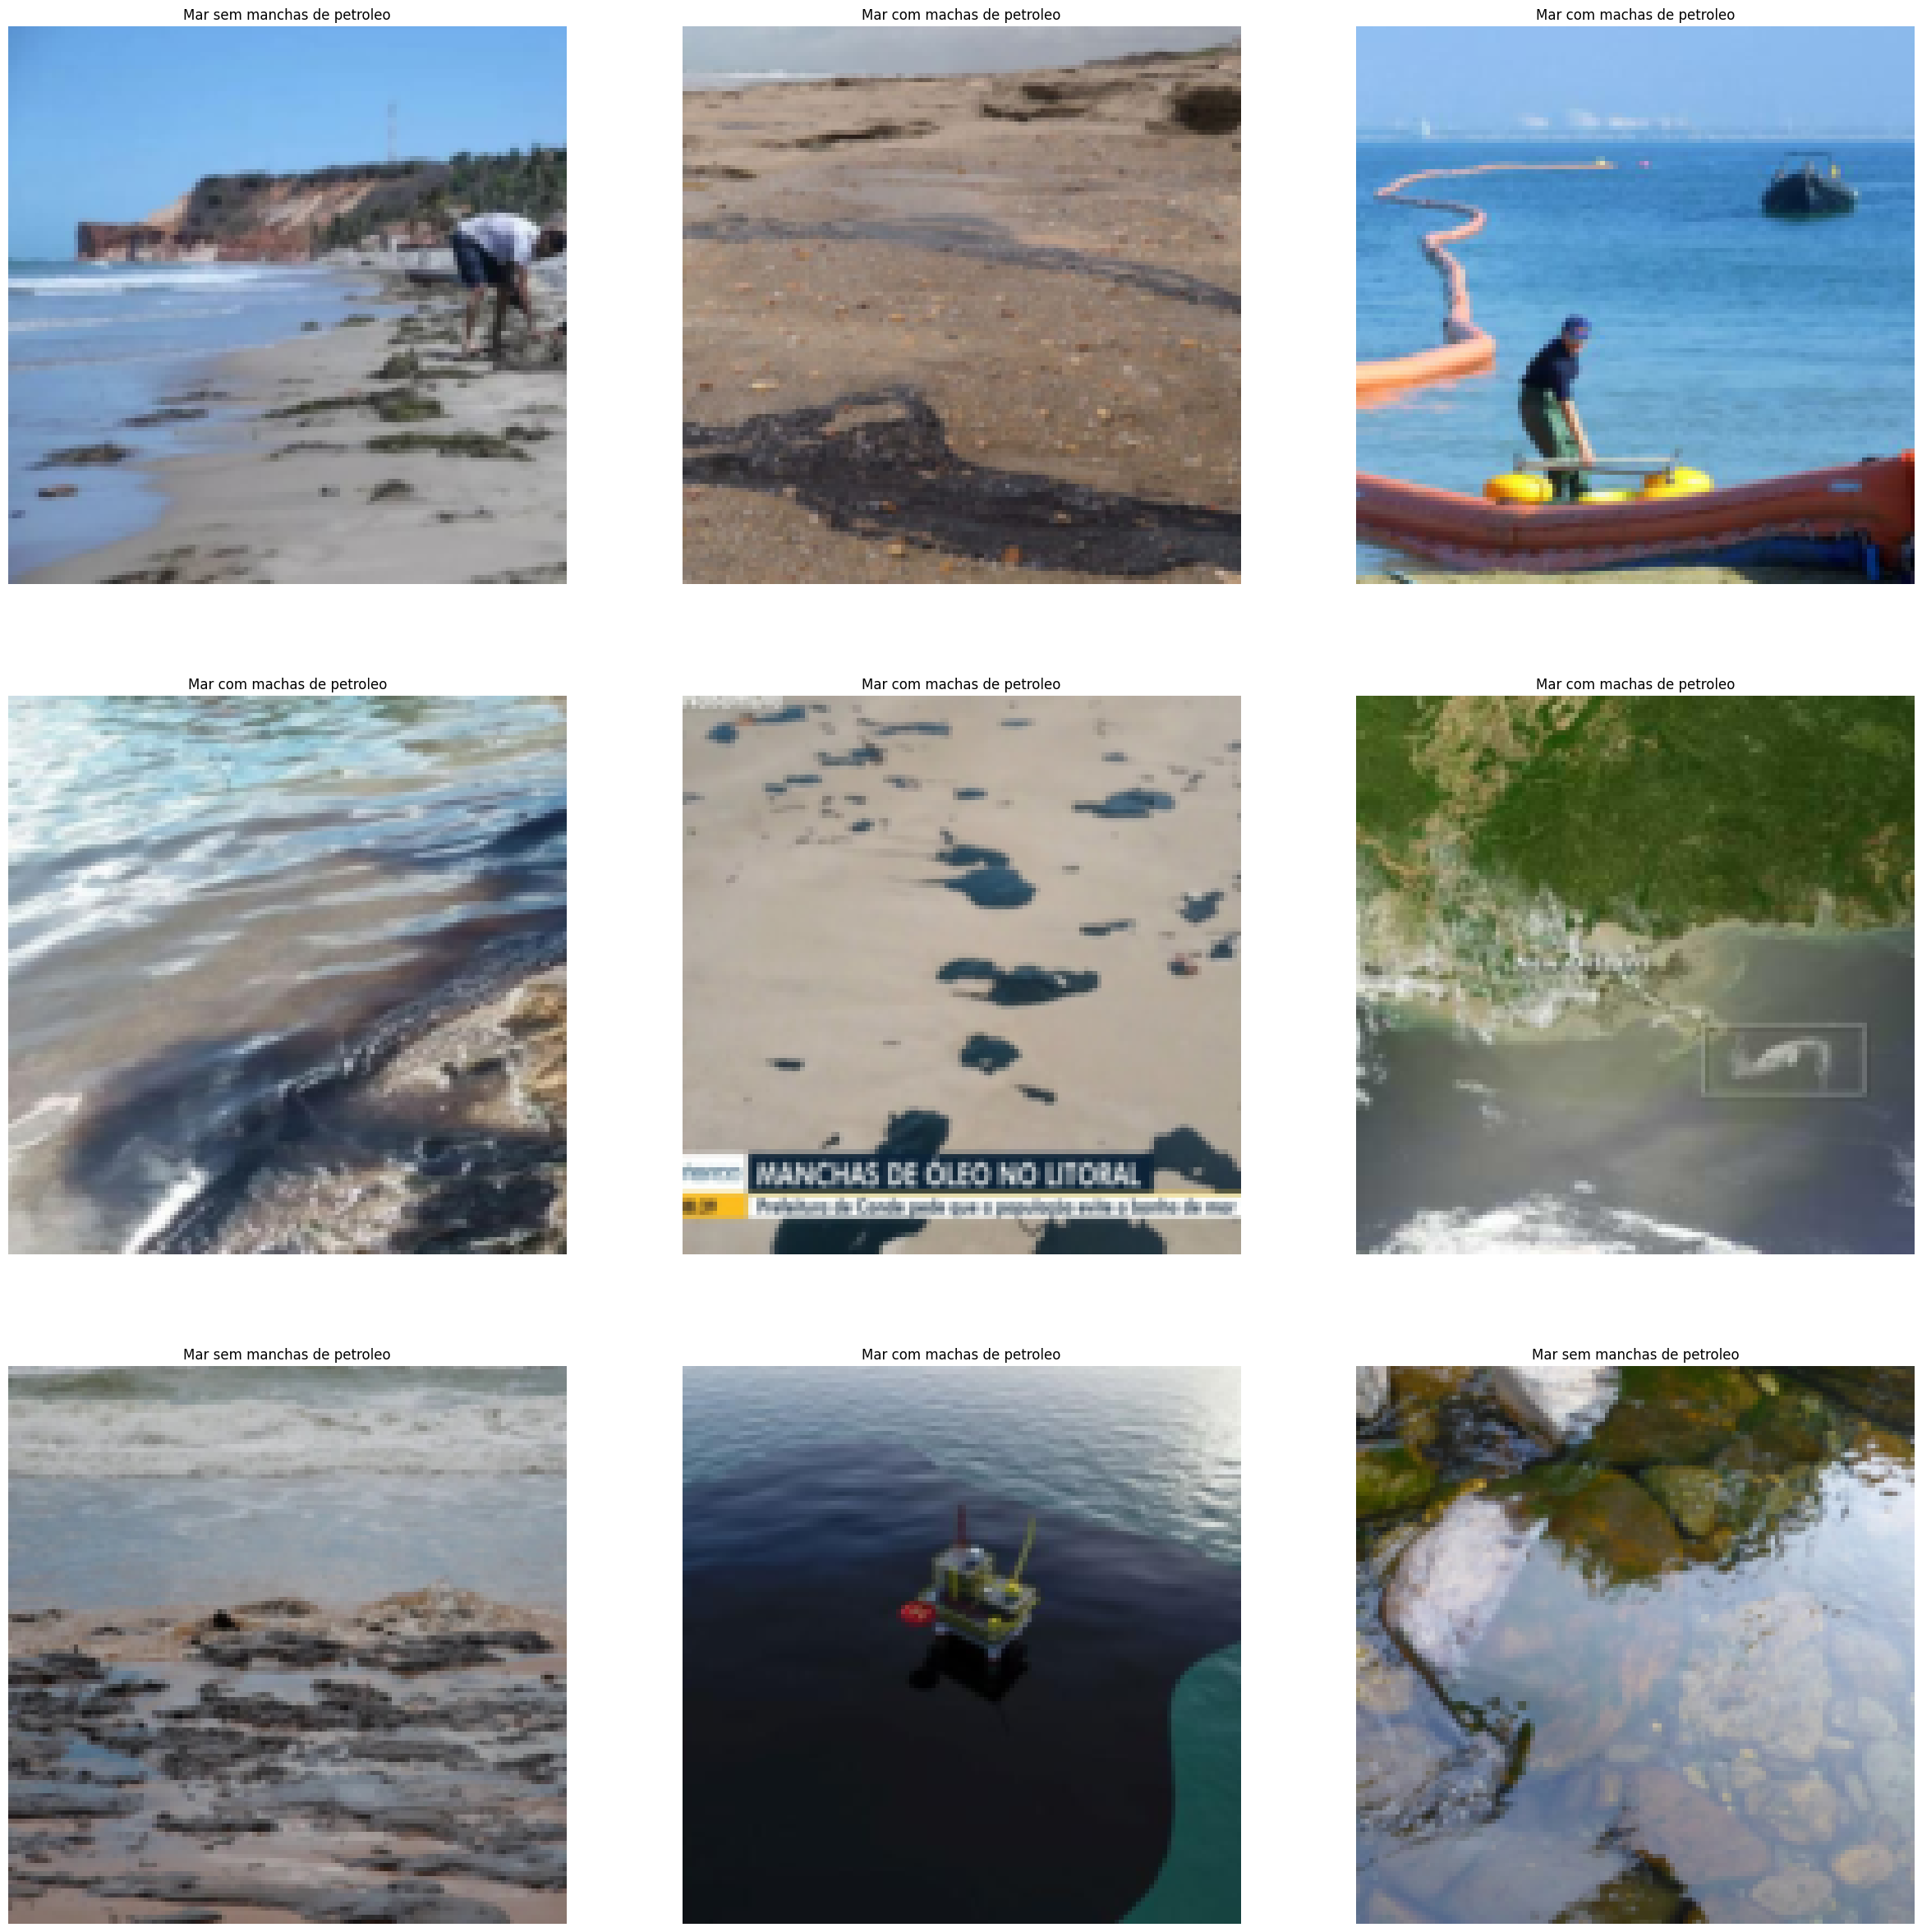

In [ ]:
path = Path("./images")

# Carrega as imagens e suas labels e ainda dividindo um grupo de teste com 20%
dataset = ImageDataLoaders.from_folder(path, item_tfms=RandomResizedCrop(128, min_scale=0.35), splitter=RandomSplitter(valid_pct=0.2, seed=42))


# visualisa o dataset
dataset.show_batch(figsize=(30, 30))

###Aqui vamos começar a treinar a IA e escolher o modelo

In [ ]:
learn = vision_learner(dataset, resnet34, metrics=error_rate)         # testar usar eficientnetv2    e cnn_learner
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.172933,2.585734,0.657143,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.201751,1.278286,0.514286,01:10
1,1.214379,1.379730,0.571429,01:05
2,1.115680,1.527313,0.514286,01:04
3,1.094718,1.446450,0.457143,01:04
4,1.042957,1.408247,0.514286,01:05
5,0.992733,1.373958,0.457143,01:05


###Aqui faremos uma análise de predição com base nos dados de treino e de teste

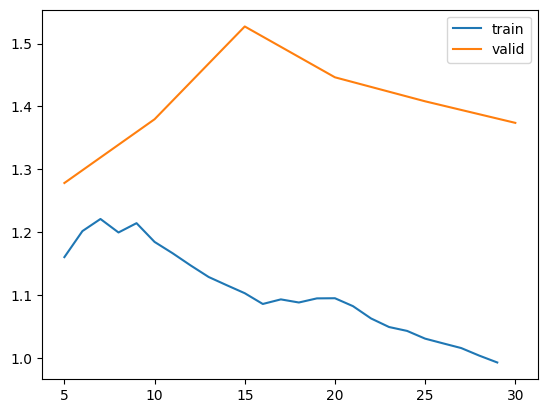

In [ ]:
# Veja a curva de Loss
learn.recorder.plot_loss()

###Vamos mostrar mais imagens do que o modelo foi capaz de gerar

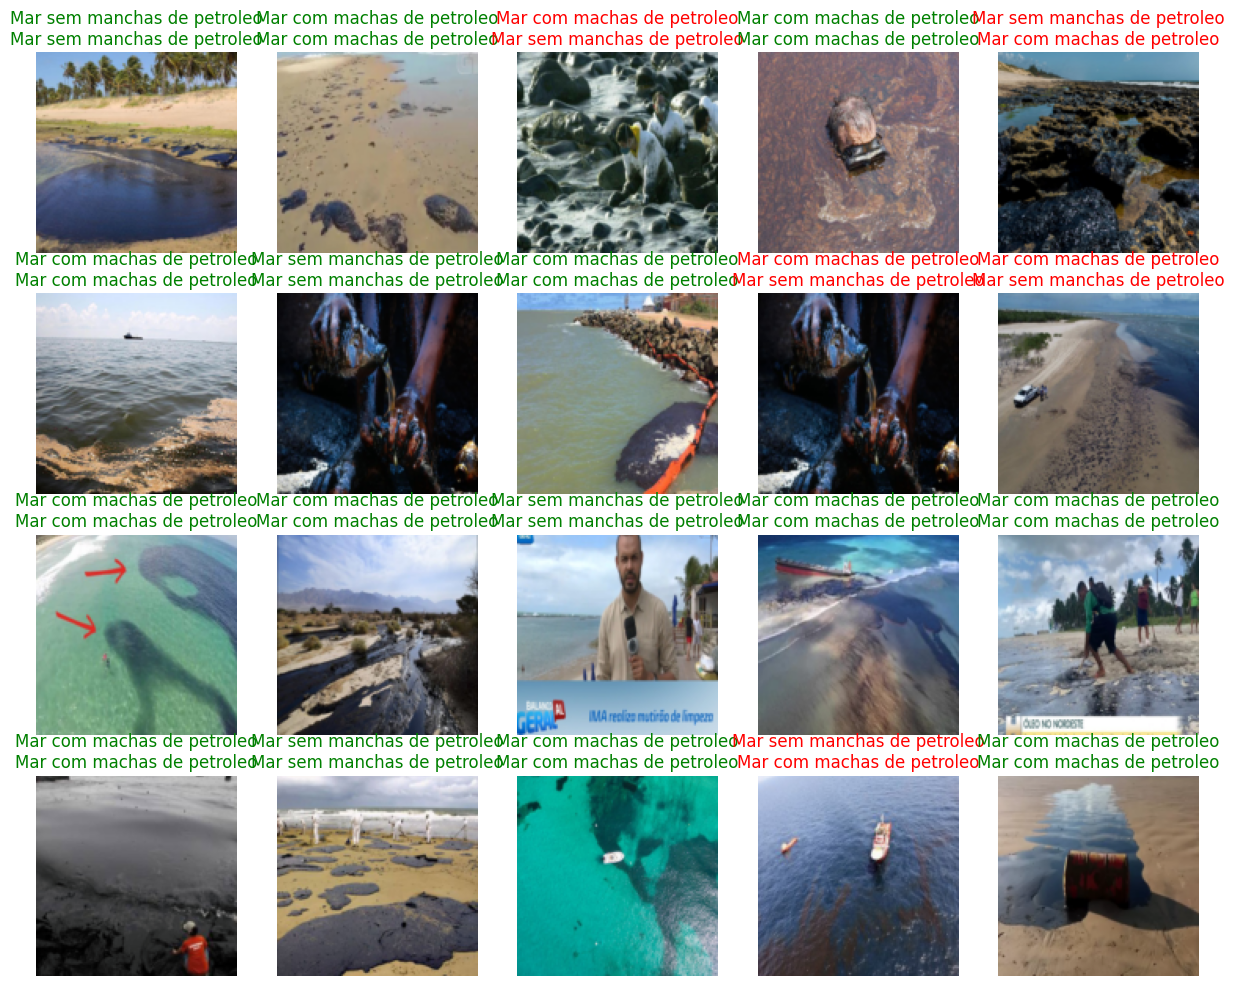

In [ ]:
learn.show_results(max_n=20)

###Gerando uma matriz de confusão

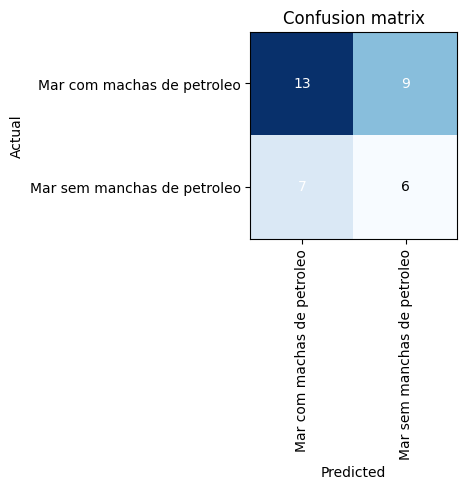

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

###Vamos medir a precisão do nosso modelo para uma imagem

In [ ]:
#Teste em uma imagem inteira

def predict(img):
    img=PILImage.create(img)
    labels = learn.dls.vocab
    pred, pred_idx, probs = learn.predict(img)
    predict_ = {labels[i]: float(probs[i]) for i in range(len(labels))}
    res = {key : round(predict_[key], 4) for key in predict_}   # aqui é só para arredondar
    return print(f'Probabilidade: {res}')

file_test = keys[0]
predict(file_test)
Image.open(file_test)


def predict(img):
    img=PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {classes[i]: float(probs[i]) for i in range(len(classes))}

Probabilidade: {'Mar com machas de petroleo': 0.4087, 'Mar sem manchas de petroleo': 0.5913}


In [ ]:
labels = learn.dls.vocab

def predict(img):
    img=PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

predict(file_test)

{'Mar com machas de petroleo': 0.4086515009403229,
 'Mar sem manchas de petroleo': 0.5913485288619995}

In [ ]:
# Exportar o modelo
learn.export()

In [ ]:
gradio.Interface(fn=predict, inputs=Image(shape=(224,224)), outputs = Label(num_top_classes=2)).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ae0212d2215d35e8b8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
